Importing Libraries

In [64]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

Collecting Data

In [65]:
ticker = 'AAPL'
stock = yf.Ticker(ticker)
time_period = 5
price = stock.history(period=f'{time_period}y')

Analysing data

In [66]:
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-11-25 00:00:00-05:00 to 2024-11-22 00:00:00-05:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1258 non-null   float64
 1   High          1258 non-null   float64
 2   Low           1258 non-null   float64
 3   Close         1258 non-null   float64
 4   Volume        1258 non-null   int64  
 5   Dividends     1258 non-null   float64
 6   Stock Splits  1258 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 78.6 KB


In [67]:
price.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03,1258.000000,1258.000000
mean,148.620496,150.270920,147.087691,148.759727,9.177720e+07,0.003595,0.003180
std,41.559058,41.769193,41.334823,41.569877,5.318783e+07,0.028374,0.112777
min,55.411093,55.513129,51.652720,54.509762,2.404830e+07,0.000000,0.000000
25%,124.592391,125.725072,123.359385,124.437263,5.660618e+07,0.000000,0.000000
50%,148.627259,150.204602,147.055739,148.964066,7.733650e+07,0.000000,0.000000
75%,175.214009,176.879456,173.613195,175.318279,1.089459e+08,0.000000,0.000000
max,235.947003,237.229001,234.192340,236.220108,4.265100e+08,0.250000,4.000000


Visualising Data

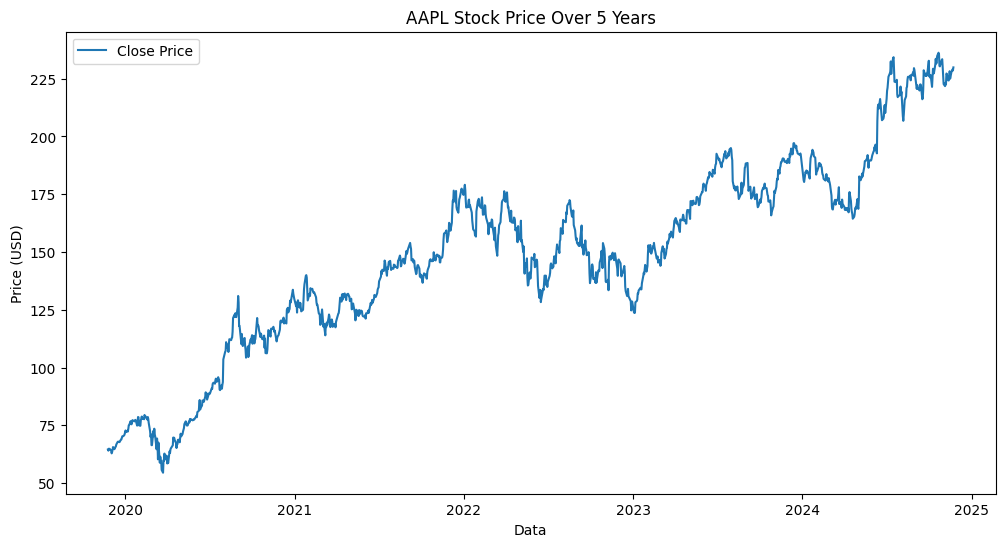

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(price['Close'], label='Close Price')
plt.title(f'{ticker} Stock Price Over {time_period} Years')
plt.xlabel('Data')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

Handling missing values

In [69]:
price.ffill(inplace=True)

Normalizing the Data

In [70]:
scaler = MinMaxScaler(feature_range=(0,1))
price_scaled = scaler.fit_transform(price[['Open', 'High', 'Low', 'Close', 'Volume']])

Preparing data for time series prediction

In [71]:
def create_sequences(data, time_steps):
    X,y=[],[]
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps, 3])
    return np.array(X), np.array(y)

In [72]:
time_steps=60
X, y = create_sequences(price_scaled, time_steps)

Train Test split

In [73]:
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Reshaping the data for LSTM model

In [74]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0],  X_test.shape[1], X_test.shape[2]))

Building the LSTM model

In [75]:
model = Sequential()
model.add(LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(LSTM(units=128, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

/home/nishant/.local/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                  │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 60, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 331,905 (1.27 MB)

 Trainable params: 331,905 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Training the model

In [78]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=10)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test,y_test), callbacks=[early_stop], verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0047 - val_loss: 0.0063
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0047 - val_loss: 0.0025
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.0053 - val_loss: 0.0090
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0045 - val_loss: 0.0029
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0042 - val_loss: 0.0043
Epoch 9/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0042 - val_loss: 0.0019
Epoch 10/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 11/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.0049 - val_loss: 0.0034
Epoch 12/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 111

30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 69/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 70/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - loss: 0.0014 - val_loss: 8.0288e-04
Epoch 71/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 72/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - loss: 0.0014 - val_loss: 8.9373e-04
Epoch 73/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 74/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 75/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 76/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.0014 - val_loss: 0.0024
Epoch 77/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 78/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 79/100
30/30 ━━━━━━━━━━━━━━━━━━

Visualising Training Loss

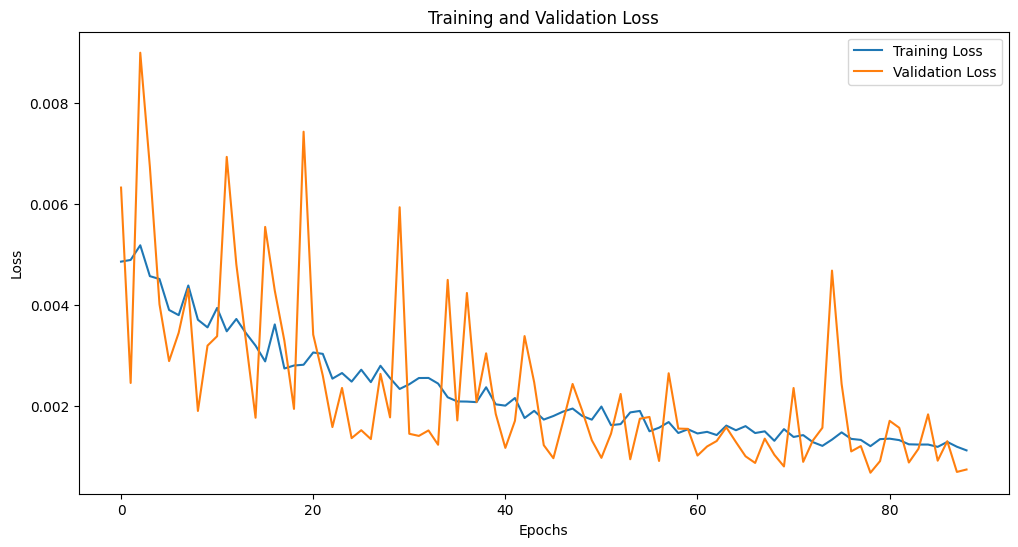

In [79]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluating the model

In [80]:
test_loss = model.evaluate(X_test, y_test, verbose=1)
test_loss

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 7.0726e-04


0.0006788570317439735

Making Predictions

In [81]:
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform([[0,0,0,pred,0] for pred in y_pred.flatten()])[:,3]
y_test_actual = scaler.inverse_transform([[0,0,0,pred,0] for pred in y_test.flatten()])[:,3]

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


Visualising Predictions vs Actual Prices

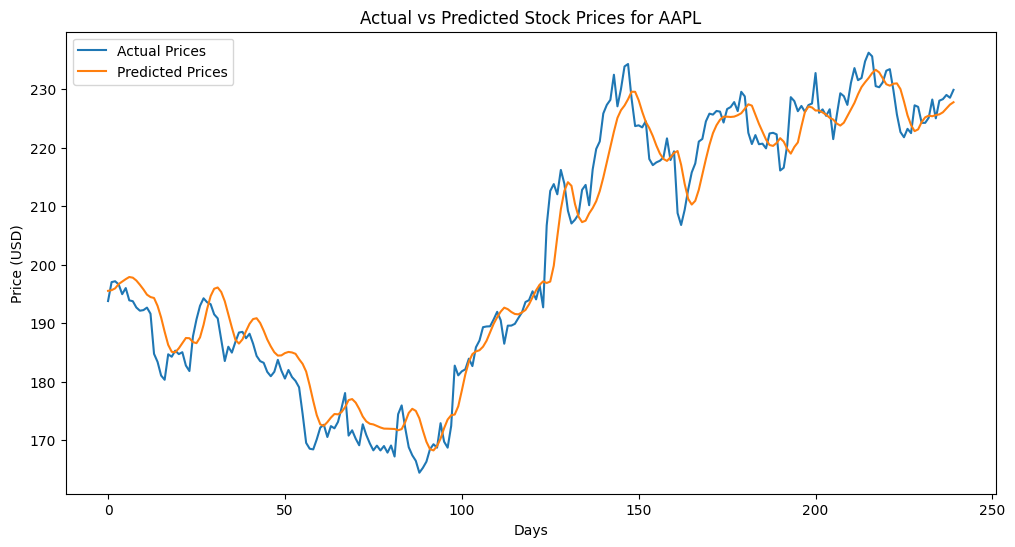

In [82]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title(f'Actual vs Predicted Stock Prices for {ticker}')
plt.xlabel('Days')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [83]:
model.save('lstm_stock_model.h5')